# MT Data-conditioned VAE

In [1]:
# pip install tensorflow

In [2]:
%load_ext autoreload
%autoreload 2

import os
import time
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy as sp
import scipy.interpolate

from cgnn import cvae_mt64_updated as vae

In [3]:
run = 's4'
if not os.path.exists(run):
    os.makedirs(run)

# Set up survey

In [4]:
def import_file(file):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    line = np.array(data, dtype=float)
    cond = line[:,25:55]
    obs_zs = line[:,286:301]
    pred_zs = line[:,348:363]
    return line,cond, obs_zs, pred_zs

In [5]:
line1,cond1, obs1, pred1 = import_file('Line1_Central-Copy1.csv')
line2,cond2, obs2, pred2 = import_file('Line2_Central-Copy1.csv')
line3,cond3, obs3, pred3 = import_file('Line3_Central-Copy1.csv')

In [6]:
np.save('Line1_Central.npy', line1)
np.save('Line1_Central_Conductivity.npy',cond1)

In [7]:
np.save('Line2_Central.npy', line2)
np.save('Line2_Central_Conductivity.npy',cond2)

In [8]:
np.save('Line3_Central.npy', line3)
np.save('Line3_Central_Conductivity.npy',cond3)

In [9]:
data1 = np.load('Line1_Central.npy')
np.load('Line1_Central_Conductivity.npy')

array([[8.604366e-03, 1.015824e-02, 1.464161e-02, ..., 1.005356e-03,
        1.002366e-03, 1.001248e-03],
       [1.009762e-02, 1.196361e-02, 1.736161e-02, ..., 1.004991e-03,
        1.002141e-03, 1.001056e-03],
       [1.138695e-02, 1.362324e-02, 2.014745e-02, ..., 1.004939e-03,
        1.002108e-03, 1.001008e-03],
       ...,
       [2.248147e+00, 4.077047e+00, 5.969859e+00, ..., 1.001711e-03,
        1.000638e-03, 1.000273e-03],
       [2.308789e+00, 3.925533e+00, 5.590547e+00, ..., 1.001747e-03,
        1.000654e-03, 1.000283e-03],
       [2.645808e+00, 4.072212e+00, 5.258405e+00, ..., 1.001731e-03,
        1.000650e-03, 1.000285e-03]])

In [10]:
data2 = np.load('Line2_Central.npy')
np.load('Line2_Central_Conductivity.npy')

array([[0.03648398, 0.04375333, 0.06125686, ..., 0.00100493, 0.00100203,
        0.001001  ],
       [0.03692505, 0.04404815, 0.06117529, ..., 0.00100488, 0.00100198,
        0.00100094],
       [0.0355793 , 0.04299819, 0.06089889, ..., 0.0010051 , 0.00100213,
        0.00100111],
       ...,
       [0.00886633, 0.01143951, 0.02004766, ..., 0.00100368, 0.00100147,
        0.00100052],
       [0.00974181, 0.01277133, 0.02308966, ..., 0.00100363, 0.00100145,
        0.0010005 ],
       [0.01089706, 0.01448192, 0.02690818, ..., 0.00100361, 0.00100145,
        0.00100052]])

In [11]:
data3 = np.load('Line3_Central.npy')
np.load('Line3_Central_Conductivity.npy')

array([[0.04755097, 0.07919228, 0.2120686 , ..., 0.00100285, 0.00100137,
        0.00100109],
       [0.0492395 , 0.08198991, 0.2180947 , ..., 0.00100285, 0.00100137,
        0.00100109],
       [0.05325513, 0.08775873, 0.2287608 , ..., 0.00100284, 0.00100136,
        0.00100107],
       ...,
       [0.013676  , 0.01695183, 0.02671344, ..., 0.00100615, 0.00100277,
        0.00100166],
       [0.01278256, 0.01582356, 0.02485566, ..., 0.00100617, 0.00100278,
        0.00100166],
       [0.01163806, 0.01427949, 0.02214111, ..., 0.00100632, 0.00100283,
        0.00100167]])

In [12]:
# remote reference frequencies
#   7.680002e+02   5.120000e+02   3.840000e+02   2.560000e+02   1.920000e+02   1.280000e+02
#   9.599997e+01   6.400000e+01   4.800001e+01   3.200000e+01   2.400000e+01   1.600000e+01
#   1.200000e+01   8.000000e+00   5.999999e+00   4.000000e+00   3.000000e+00   2.000000e+00
#   1.500000e+00   1.000000e+00   7.500002e-01   5.000000e-01   3.750000e-01   2.500000e-01
#   1.875000e-01


# mesh
# 64 ft
cell_size = 30*0.3048
depth_to_top = 30*0.3048
n_cells = 30
# one fewer depth; last cell extends to inf
#depths = depth_to_top + np.arange(1,n_cells)*cell_size
#depths to bottom
depths = np.array([4,8.4,13.24,18.56,24.42,30.86,37.95,45.74,54.31,63.74,74.11,85.52,98.07,111.88,127.07,143.78,162.16,182.38,204.62,229.08,255.99,285.59,318.15,353.97,393.37,436.71,484.38,536.82,594.5])
n_depths = len(depths)
print(n_depths)
# data frequencies
# conservative, lines up with remote referenced stations, minus one frequency to avoid extrapolation
f_a = np.logspace(-2, 9, num=12, base=2)
f_b = np.logspace(-4, 7, num=12, base=2)*3
times = np.array([0.013,0.039,0.065,0.104,0.169,0.273,0.443,0.703,1.094,1.693,2.63,4.102,6.406,9.961,16.055])
# frequencies = np.logspace(-4, 10, 15, base=2)
nt = len(times)
print(nt)
# data are only real
ndata = nt

29
15


In [13]:
# x = np.arange(depths.size)
# new_length = 63
# new_x = np.linspace(x.min(), x.max(), new_length)
# new_depths = sp.interpolate.interp1d(x, depths)(new_x)
# print(new_depths)
# print(len(new_depths))
# depths = new_depths

# Load training models and Create neural network

In [14]:
# normalize model parameters between -1 and 1
# remember, min resistivity is 0.01, max is 1e5
# Gaussian infill potentially allows for values outside this range, but not likely
min_model = np.log(1e-5)
max_model = np.log(1e5)
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1

# create network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times = times,
                   norm_pad=norm_pad,
#                    data_std=0.1,
#                    model_std=.01,
                   beta_vae=1,
                   model_loss_type='ae',
                   data_loss_type='se'
                  )

C:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [15]:
# Due to ranging orders of magnitude - recommended to keep
def preprocess(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(1/np.load(filename))
    x = x.reshape(-1, n_cells, 1)
    return x

x_train_log = preprocess('Line1_Central_Conductivity.npy')
x_validate_log = preprocess('Line3_Central_Conductivity.npy')
x_test1_log = preprocess('Line2_Central_Conductivity.npy')
# x_test2_log = preprocess('KGS_RILD_64ft_test2.npy')

x_train = network.model_to_tanhs(x_train_log)
x_validate = network.model_to_tanhs(x_validate_log)
x_test1 = network.model_to_tanhs(x_test1_log)
# x_test2 = network.model_to_tanhs(x_test2_log)
print(np.min(x_train))
print(np.max(x_train))

-0.23346378617581356
0.5400728129689761


In [16]:
x_train1 = x_train[0:100,]
x_validate1 = x_validate[0:100,]
print(x_train1.shape)

(100, 30, 1)


In [1]:
# compute stds
model_std = np.std(x_train.flatten())
#mt_data_file = 'KGS_MT.npy'
#os.remove(mt_data_file)
#try:
#    all_data = tf.convert_to_tensor(np.load(mt_data_file))
#except FileNotFoundError:
#    all_data = network.predict_tanh(x_train)
#    np.save(mt_data_file, all_data.numpy())
train_data = network.predict_tanh(x_train1)
# print(train_data)
print("train data", train_data.shape)
print('.......')
log_train_data = tf.math.log(-train_data)
#print('log_train_data'log_train_data.shape)
print("log_train_data", log_train_data.shape)

validate_data = network.predict_tanh(x_validate1)
log_validate_data = tf.math.log(-validate_data)

# test1_data = network.predict_tanh(x_test1)
# log_test1_data = tf.math.log(-test1_data)

# test2_data = network.predict_tanh(x_test2)
# log_test2_data = tf.math.log(-test2_data)

# # Create batches and shuffle
BATCH_SIZE = 50

#x_train1 = models *log transform models*; log_train_data: raw data

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train1, tf.float32), 
    tf.cast(log_train_data, tf.float32))).shuffle(10000).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_validate1, tf.float32),
    tf.cast(log_validate_data, tf.float32))).shuffle(10000).batch(x_validate1.shape[0])

# though the data vary over several orders of magnitude, 
# they don't vary so much within one frequency.
# data_std_vec = np.std(train_data.numpy(), axis=0)
# log_data_std_vec = np.std(log_train_data.numpy(), axis=0)
# log_data_std = np.std(log_train_data.numpy().flatten())
# average_log_data_std = np.std((log_train_data.numpy() - log_train_data.numpy().mean(axis=0)).flatten())
# print(model_std, log_data_std, average_log_data_std)
# compute elementwise stds
model_std_vec = np.std(x_train1, axis=0)
model_std_vec = np.reshape(model_std_vec, (n_cells))
# # compute relative std
mean_train_data = np.mean(train_data.numpy(), axis=0)
rel_data_std = np.abs(mean_train_data)

# same for model, but mean over all
mean_model_value = np.mean(x_train1)
rel_model_std = 0.5*mean_model_value
print(mean_model_value, rel_model_std)

NameError: name 'np' is not defined

In [32]:
# finalize network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times=times,
                   norm_pad=norm_pad,
                   data_std=rel_data_std.reshape(1, -1, 1),
#                    model_std=model_std,
                   model_std=model_std_vec.reshape(1, -1, 1),
                   latent_dim=20,
                   beta_vae=1,
                   model_loss_type='se',
                   data_loss_type='se'
                  )

# double check forward model
'''

all_data[0, 0], all_data[0, 24]

network.predict_tanh(x_train[0:1])

c60 = np.load('KSG_RILD_60ft.npy')
c60[0].shape

vae.forward_1_freq(c60[200], depths, frequencies[0])[0]

vae.forward_1_freq(c60[200], depths, frequencies[-1])[0]

all_data.numpy().max(), all_data.numpy().min()

all_data.shape

'''

#for i_freq in range(nf):
#    plt.hist(all_data.numpy()[:, i_freq].flatten(), bins=50)

"\n\nall_data[0, 0], all_data[0, 24]\n\nnetwork.predict_tanh(x_train[0:1])\n\nc60 = np.load('KSG_RILD_60ft.npy')\nc60[0].shape\n\nvae.forward_1_freq(c60[200], depths, frequencies[0])[0]\n\nvae.forward_1_freq(c60[200], depths, frequencies[-1])[0]\n\nall_data.numpy().max(), all_data.numpy().min()\n\nall_data.shape\n\n"

In [33]:
# May be able to remove/adjust steps since I have data instead of models
i_random_train = np.arange(16)
# random_train = x_train[i_random_train].reshape((16, n_cells))
# pick some random training models
# i_random_train = np.random.randint(0, x_train1.shape[0], 16)
#i_random_train = np.arange(16)
random_train = x_train1[i_random_train].reshape((16, n_cells))
print('i_random_train',i_random_train.shape)
print('random_train',random_train.shape)
# predict their data
random_data = network.predict_tanh(random_train.reshape(16, n_cells, 1))
print('n_cells',n_cells)
random_log_data = tf.math.log(-random_data)
print('random_log_data', random_log_data.shape)
print('random_data',random_data.shape)
# Save data and latent space inputs for plots
# print(network.latent_dim)
latent_input = tf.random.normal([16, network.latent_dim], seed=0, dtype=tf.float32)
# print(latent_input)
print('n_data',network.n_data)
data_input = tf.reshape(random_log_data,(16,network.n_data))
print(data_input)
zd_input = tf.concat((latent_input,data_input),axis=-1)
print(zd_input)
# Why are there nan values????? The forward modelling produces (16,30) arrays which should fit perfectly into data_input
#

i_random_train (16,)
random_train (16, 30)
tanhs (16, 30, 1)
nc 30
Zss (16, 30)
xn (16, 30)
dpred [-3.74183070e-12  4.44009381e-13  2.91814493e-13  1.68612720e-13
  7.81583451e-14  2.92452760e-14  8.83298537e-15  2.62603821e-15
  9.59332086e-16  4.56272893e-16  2.51044009e-16  1.44984805e-16
  8.49937183e-17  5.00022544e-17  2.77603898e-17  6.23714874e-11
 -8.14143654e-12 -4.45883479e-12 -2.21306936e-12 -8.40448411e-13
 -2.44495194e-13 -5.23489619e-14 -9.47507294e-15 -1.73424841e-15
 -3.99860378e-16 -1.21620095e-16 -4.26845324e-17 -1.58558596e-17
 -6.08702164e-18 -2.17374463e-18]
EM [-3.74183070e-12  4.44009381e-13  2.91814493e-13  1.68612720e-13
  7.81583451e-14  2.92452760e-14  8.83298537e-15  2.62603821e-15
  9.59332086e-16  4.56272893e-16  2.51044009e-16  1.44984805e-16
  8.49937183e-17  5.00022544e-17  2.77603898e-17  6.23714874e-11
 -8.14143654e-12 -4.45883479e-12 -2.21306936e-12 -8.40448411e-13
 -2.44495194e-13 -5.23489619e-14 -9.47507294e-15 -1.73424841e-15
 -3.99860378e-16 -1.

In [34]:
# plot a few random training models and their data
# vae.plot_complex(random_data, times=times, save2file=True, filename=run+'/training_MT_data.png')
vae.plot_logs(np.exp(network.tanhs_to_model(random_train)), depths=depths, save2file=True, 
              filename=run + '/training_models.png')

# Save starting plots
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                    latent=zd_input,step=0)
# network.plot_data(save2file=True,folder=run,latent=zd_input,step=0)
# network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=0)

plt.close('all')
plt.clf()
gc.collect()

53740

<Figure size 640x480 with 0 Axes>

In [27]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

# Train

In [28]:
epochs = 10

In [35]:
validate_terms = []
train_terms = []
train_losses = []
ttest_losses = []
# print(len(train_dataset))
for epoch in range(1, epochs + 1):
    start_time = time.time()
#     print(train_dataset)
#     print(optimizer)
    for train_x in train_dataset:#.batch(BATCH_SIZE):
        # print(len(train_x[1]))
        if len(train_x[1]) == 80:
            train_loss, train_term = vae.compute_apply_gradients(network, train_x, optimizer, 
                                    use_data_misfit=False)
        #train_losses.append(train_loss.numpy())
            train_terms.append([tt.numpy() for tt in train_term])
        else:
            continue
#         for test_x in test_dataset:
#             ttest_loss = vae.compute_losses(network, test_x)
#             terms = [loss(l).numpy() for l in ttest_loss]
#             ttest_losses.append(terms)
    end_time = time.time()

    # compute and save losses
    for val_x in validate_dataset:#.batch(BATCH_SIZE):
        val_loss, val_term = vae.compute_loss(network, val_x)
        #terms = [tf.reduce_mean(l).numpy() for l in losses]
        #loss(vae.compute_reconstruction_loss(network, test_x))
    #elbo = -loss.result()
    validate_terms.append([tt.numpy() for tt in val_term])
    print('Epoch: {}, Data misfit: {:.4}, '
          'Reconstruction: {:.4}, '
          'KL: {:.4}, '
          'Elapsed {:.4} s'.format(epoch, val_term[0], val_term[1], val_term[2],
                                #elbo,
                                end_time - start_time))
        
    if epoch % 1e3 == 0:
        network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                 latent=zd_input,step=epoch)
        network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)
        network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)
        plt.close('all')
        gc.collect()

network.inference_net.save(run+'/encoder.h5')
network.generative_net.save(run+'/decoder.h5')
#np.save(run+'/optimizer_weights.npy', optimizer.load_weights())
np.save(run+'/losses.npy', np.array(validate_terms))
np.save(run+'/train_losses.npy', np.array(train_terms))
# WHERE IS THE 35 COMING FROM????

d_input: Tensor("xy_1:0", shape=(100, 30), dtype=float32)
zd: Tensor("concat:0", shape=(100, 50), dtype=float32)
tanhs (100, 32, 1)
ys <unknown>
ys_test <unknown>
network n_model: 30
x_tanh: (100, 30, 1)
Tensor("strided_slice_1:0", shape=(32, 1), dtype=float32)
Tensor("strided_slice_2:0", shape=(30, 1), dtype=float32)
x: (100, 30, 1)
x_tanh tensor: Tensor("transpose_2:0", shape=(30, 100), dtype=float32)
x tensor: Tensor("transpose_3:0", shape=(30, 100), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)
nc 32
Zss (100, 30)
xn (100, 32)
dpred [-8.36745244e-13  1.30943630e-13  3.34856331e-14  1.06007087e-14
  3.34895457e-15  1.08379991e-15  3.46513671e-16  1.16061927e-16
  4.04286993e-17  1.41713480e-17  4.88906745e-18  1.66001360e-18
  5.58655342e-19  1.88935190e-19  5.80240718e-20  9.68727500e-11
 -9.73608367e-12 -1.29599365e-12 -2.44429264e-13 -4.67100216e-14
 -9.33521148e-15 -1.84695184e-15 -3.92356350e-16 -8.84261857e-17
 -2.01610446e-17 -4.50481061e-18 -9.86115167e-19 -2.13

C:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
         latent=zd_input,step=epoch)

In [37]:
network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)

tanhs (16, 32, 1)
nc 32
Zss (16, 30)
xn (16, 32)
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
EM [nan nan nan nan nan nan nan nan nan nan nan nan na

In [38]:
# something weird here
network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)

tanhs (16, 32, 1)
nc 32
Zss (16, 30)
xn (16, 32)
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
EM [nan nan nan nan nan nan nan nan nan nan nan nan na

ValueError: all input arrays must have the same shape

In [41]:
plt.close('all')
plt.clf()
gc.collect()

27659

<Figure size 640x480 with 0 Axes>

# Load networks

In [42]:
network.inference_net = tf.keras.models.load_model(run+'/encoder.h5')
network.generative_net = tf.keras.models.load_model(run+'/decoder.h5')

In [43]:
loss_terms = np.load(run+'/losses.npy')

In [44]:
#optimizer_weights = np.load(run+'/optimizer_weights.npy', allow_pickle=True)

https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state to train more

# Plot loss over epochs

In [45]:
plt.rcParams.update({'font.size': 18})

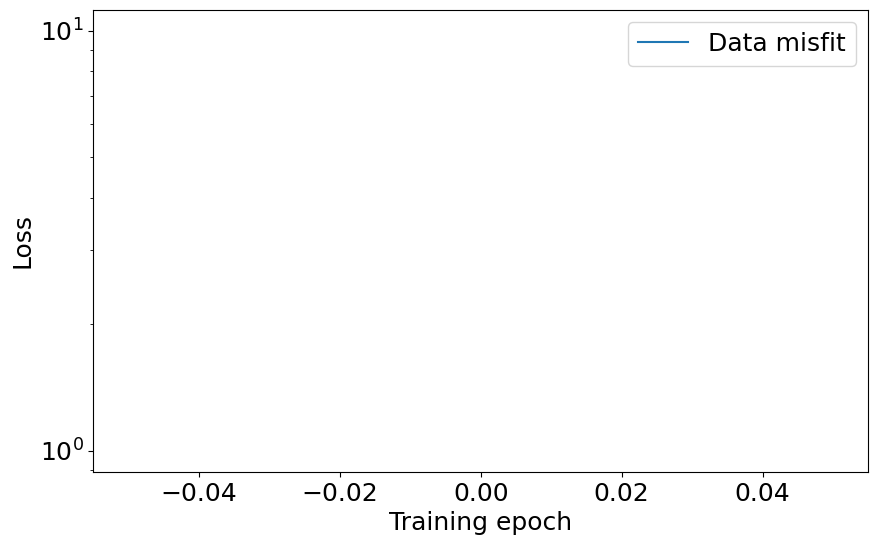

In [46]:
tt = np.array(train_terms)
batches_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_batches = tt.shape[0]
plt.figure(figsize=(10,6))
plt.semilogy(np.arange(num_batches)/batches_per_epoch, tt)
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('training_loss_'+run+'_w.png')
plt.show()

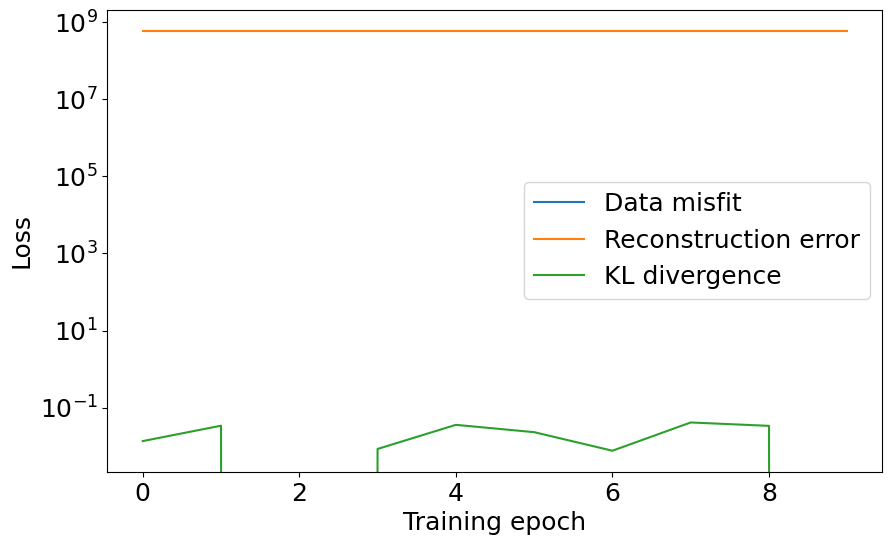

In [47]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs),validate_terms)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('validation_loss_'+run+'_w.png')
plt.show()

# View some tests

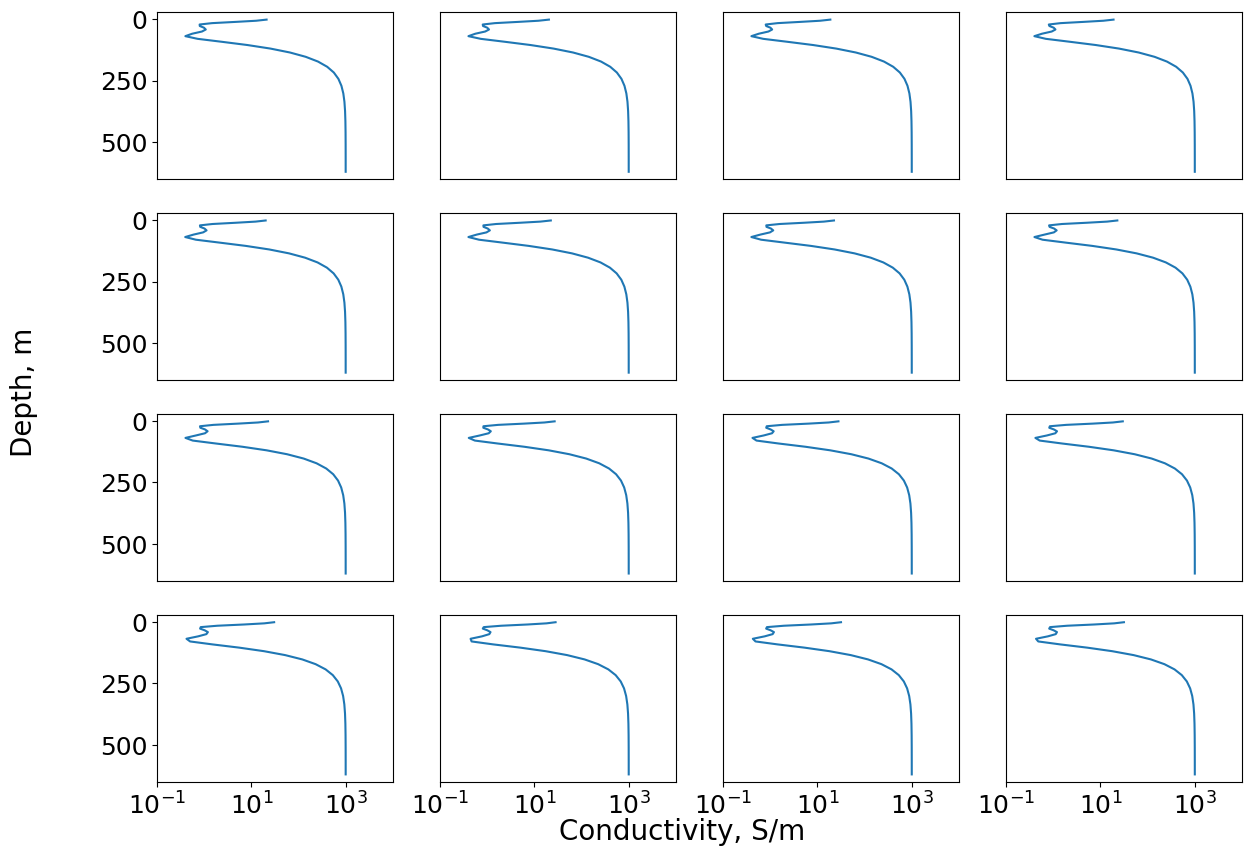

In [48]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_validate[0:16])), depths=depths)

tf.Tensor(
[[ 7.38216877e-01 -1.01667094e+00  1.86122656e-01  2.08698940e+00
   1.06710243e+00 -1.26171529e+00  1.58678734e+00  7.89353848e-02
   5.64184487e-01 -6.51486337e-01 -1.76360220e-01  1.41615927e+00
   1.04309678e-01 -4.92404327e-02 -2.12552205e-01  2.55491400e+00
   1.61800826e+00 -6.24241710e-01  2.47373417e-01 -4.72559184e-01
  -2.67963486e+01             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
  -2.42453308e+01 -2.64360561e+01 -2.84965458e+01 -3.02848816e+01
  -3.16298828e+01 -3.27917442e+01 -3.38262634e+01 -3.47831917e+01
  -3.57101898e+01 -3.66357346e+01 -3.75658722e+01 -3.84998055e+01
  -3.94308624e+01 -4.04514542e+01]
 [ 1.59650517e+00  4.20108825e-01 -1.49467611e+00  5.28526545e-01
   1.05871782e-01  2.88502634e-01 -1.99412644e+00  2.23221469e+00
   1.93601465e+00  1.05948734e

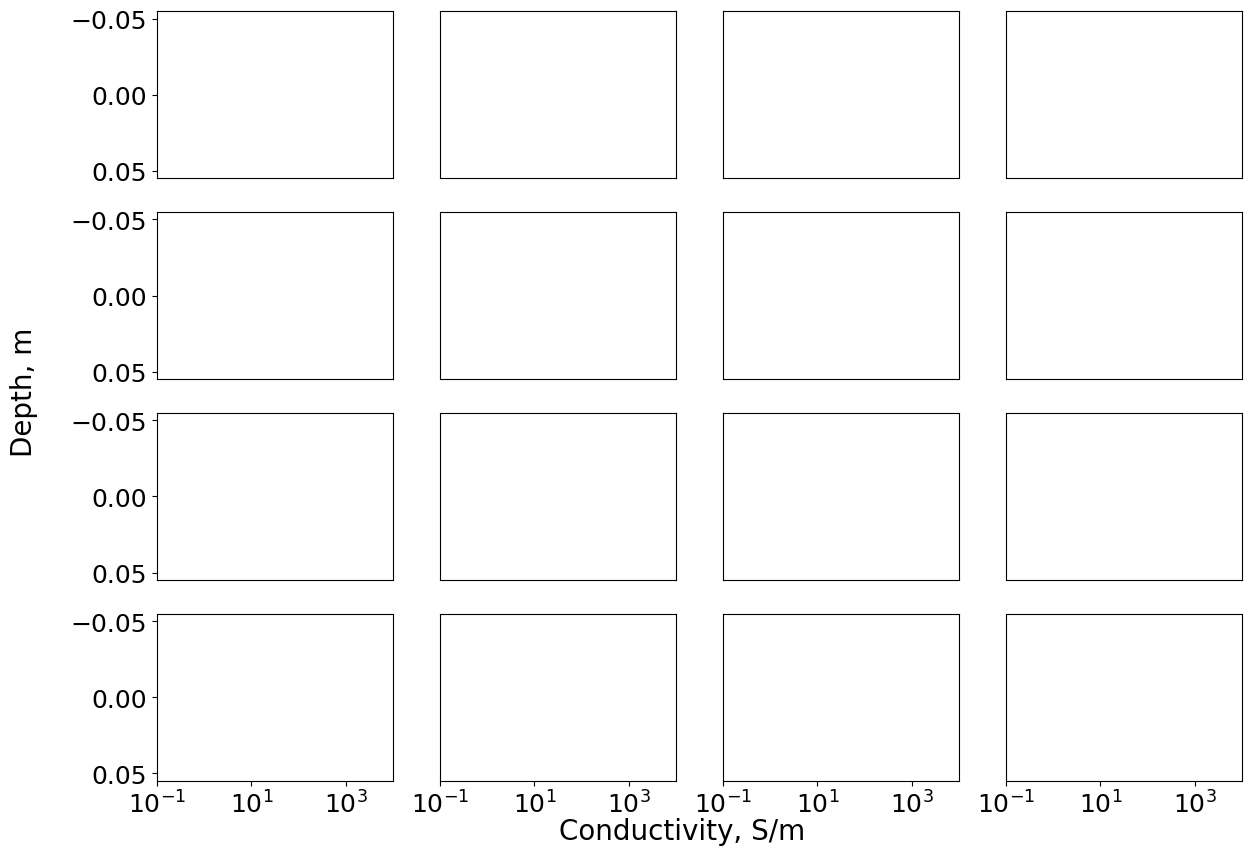

In [49]:
z_model = network.reparameterize(*network.encode(x_validate[0:16]))
z_data = log_validate_data[0:16]
zmd = tf.concat((z_model,z_data),-1)
print(zmd)
network.plot_models(latent=zmd)

In [50]:
def minmax(x): return tf.reduce_min(x), tf.reduce_max(x)

In [51]:
tanhs = network.decode(zmd, apply_tanh=True)
minmax(tanhs)

(<tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>)

In [52]:
minmax(x_test1[0:16])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.03254183984457575>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5399266299885006>)

tanhs (16, 32, 1)
nc 32
Zss (16, 30)
xn (16, 32)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan

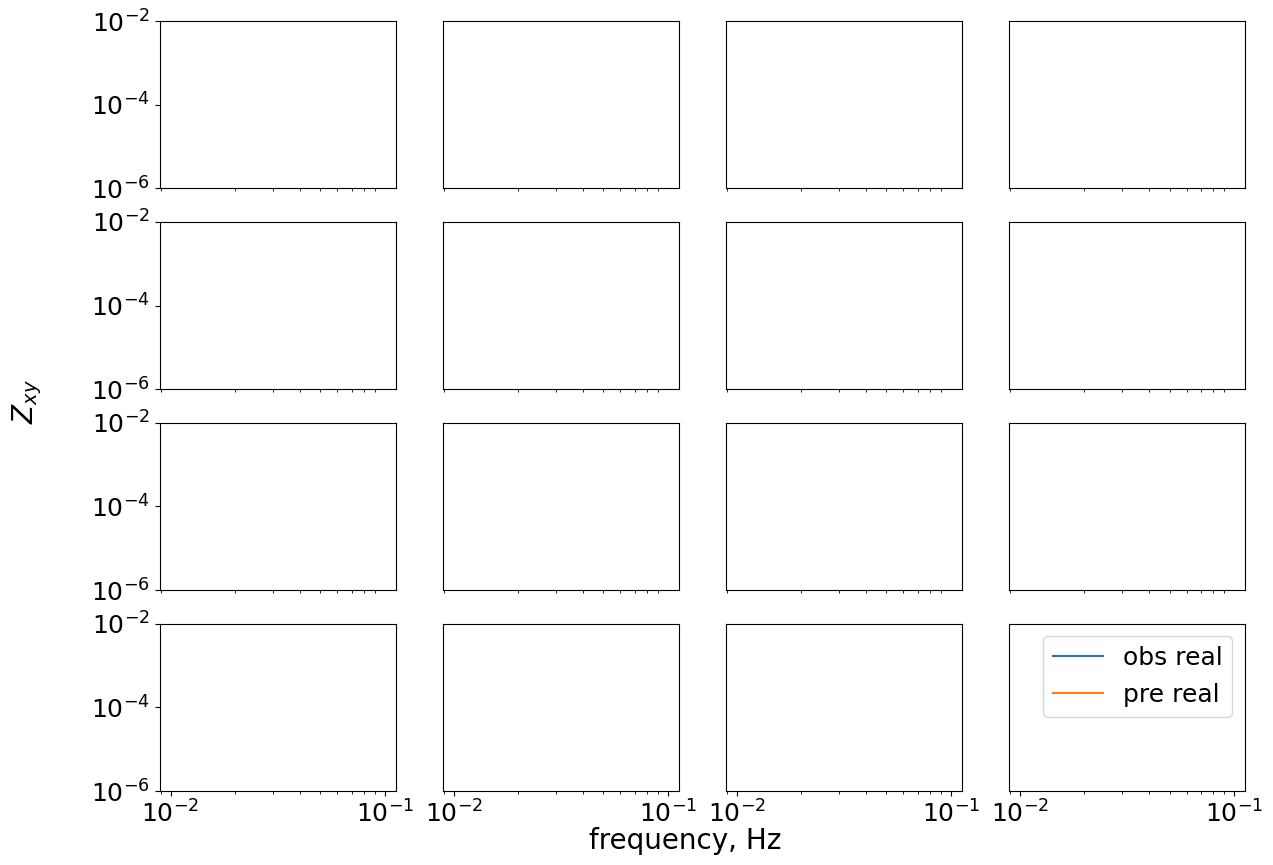

In [53]:
network.plot_data(latent=zmd)

In [54]:
network.plot_residuals(latent=zmd, ylims=(1e-6, 1e-1), weighted=False)

tanhs (16, 32, 1)
nc 32
Zss (16, 30)
xn (16, 32)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
dpred (30,)
dpred (30,)
EM [nan nan nan nan nan nan nan nan nan

ValueError: all input arrays must have the same shape

# Randomize latent; does data still fit?

In [ ]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_test1[0:16])), depths=depths)

In [ ]:
print(x_test1[0:1].shape)

In [ ]:
data0 = tf.tile(z_data[0:1],[16,1])
zmd2 = tf.concat((latent_input,data0),-1)

In [ ]:
network.plot_models(latent=zmd2)

In [ ]:
zmd2_tanhs = network.decode(zmd2, apply_tanh=True)
zmd2_samples = zmd2_tanhs.shape[0]
zmd2_tanhs = np.reshape(zmd2_tanhs, (zmd2_samples, network.n_model))
zmd2_logs = np.exp(network.tanhs_to_model(zmd2_tanhs))

In [ ]:
zmd2_logs.shape

In [ ]:
depth_centers = (network.depths[1:] + network.depths[:-1])/2
plot_depths = np.r_[
    depth_centers[0] - (depth_centers[1] - depth_centers[0]),
    depth_centers,
    depth_centers[-1] + depth_centers[-1] - depth_centers[-2]
]

In [ ]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    if len(log) != len(plot_depths):
        log = np.delete(log, [-2,-1])
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(1e-1, 1e4)
ax.axes.set_title('Generated Conductivity Plots')
plt.tight_layout()
plt.savefig('Preliminary_generated_plots.jpg')
plt.show()

In [ ]:
network.plot_data(latent=zmd2)

In [ ]:
#log_data_test[0]

In [ ]:
-tf.exp(zmd2[0, 50:])

In [ ]:
# network.predict_tanh(network.decode(zmd2, apply_tanh=True))[0]

In [ ]:
network.plot_residuals(latent=zmd2, ylims=(1e-3, 1e-8), weighted=True)

In [ ]:
y_true = [[0., 0.], 
          [0., 0.]]
y_pred = [[3., 0.], 
          [2., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
# Using 'none' reduction type.
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
# Calling with 'sample_weight'.
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()


In [ ]:
1/2*((3-0)**2 + 0**2)*.7, 1/2*((2-0)**2 + (0-0)**2)*.3

In [ ]:
network.data_weights

In [ ]:
print(cond2[0])
print(cond2[1])

In [ ]:
num_plots = 4
fig = plt.figure(figsize=(8, 10))
for i in range(0, num_plots):
    ax = plt.subplot(int(num_plots),2,i+1)
    ax.plot(times, -obs2[i], -pred2[i])
    plt.xlabel('Time (s)')
    plt.ylabel('dB/dt')
    plt.legend(['Observed','Predicted'])
plt.tight_layout()
plt.savefig('Raw_Time_Decay_Curves_Line2_Central.jpg')

In [ ]:
print(len(cond2))

In [ ]:
depths1 = np.append(depths,[652])
fig, ax = plt.subplots()
ax.semilogx(cond2[0], depths1, c='k', alpha=0.2)
ax.semilogx(cond1[0], depths1, c='k',alpha=0.2)
ax.invert_yaxis()
# ax.axes.set_xlim(1e-2, 1e4)
plt.xlabel('Conductivity')
plt.ylabel('Depth')
plt.tight_layout()
plt.savefig('Raw_ConductivityvsDepth_Line2_Central.jpg')
plt.show()